In [1]:
from wencailib.data.jqsdk import jq_auth
jq_auth()

提示：当前环境 pandas 版本高于 0.25，get_price 与 get_fundamentals_continuously 接口 panel 参数将固定为 False
注意：0.25 以上版本 pandas 不支持 panel，如使用该数据结构和相关函数请注意修改
auth success 


In [2]:
from jqdatasdk import *

In [564]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
import datetime as dt
from tqdm import tqdm
import os
import copy

In [340]:
def str2date(date):
    dt_datetime = datetime.datetime.strptime(date, '%Y-%m-%d')
    dt_date = datetime.datetime.date(dt_datetime)
    return dt_date

In [26]:
# Realized Volatility
und_price = get_price(['510050.XSHG'],start_date='2020-01-01', end_date='2021-05-01', frequency='daily') #Use jqdata!!!

In [132]:
time_index = pd.DatetimeIndex(und_price.set_index(und_price['time']).index)

In [348]:
date_list = [date for date in time_index.strftime('%Y-%m-%d')]

In [133]:
und_price = und_price.set_index(time_index)

In [30]:
und_price['RV'] = np.sqrt(0.5 * np.power(np.log(und_price['high'] / und_price['low']), 2) - 
                          (2 * np.log(2) - 1) * np.power(np.log(und_price['close'] / und_price['open']), 2))

In [134]:
und_price[10:]

,time,code,open,close,high,low,volume,money,RV,returns,HistV
time,,,,,,,,,,,
2020-01-16,2020-01-16,510050.XSHG,3.011,2.992,3.014,2.984,392499499.0,1.176398e+09,0.005878,-0.003337,0.006537
2020-01-17,2020-01-17,510050.XSHG,2.997,2.998,3.019,2.990,578118827.0,1.733918e+09,0.006822,0.002003,0.006541
2020-01-20,2020-01-20,510050.XSHG,3.012,3.014,3.016,3.001,466456016.0,1.403799e+09,0.003501,0.005323,0.006536
2020-01-21,2020-01-21,510050.XSHG,2.996,2.964,2.999,2.961,582564024.0,1.733470e+09,0.006063,-0.016728,0.008448
2020-01-22,2020-01-22,510050.XSHG,2.957,2.963,2.970,2.914,748458499.0,2.206473e+09,0.013401,-0.000337,0.007979
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,2021-04-26,510050.XSHG,3.524,3.458,3.543,3.451,730601406.0,2.552019e+09,0.014423,-0.016065,0.010574
2021-04-27,2021-04-27,510050.XSHG,3.456,3.466,3.475,3.444,475711945.0,1.645674e+09,0.006077,0.002311,0.010439
2021-04-28,2021-04-28,510050.XSHG,3.450,3.467,3.470,3.433,683757117.0,2.358016e+09,0.006937,0.000288,0.010428


In [32]:
# History Volatility
und_price['returns'] =  np.log(und_price['close'] / und_price['close'].shift(1))

In [82]:
und_price['HistV'] = und_price['returns'].rolling(window = 10).std() * np.sqrt(10 / 9)

In [114]:
# Volatility Threshold
vol_threshold = np.percentile(und_price[10:]['HistV'], 70)

In [576]:
# Read preopen dataset
opt_df = pd.read_csv('daily_option_preopen.csv')
opt_df2 = opt_df[opt_df['date'] < '2021-05-01'].copy()
opt_info = copy.deepcopy(opt_df2.set_index(['date', 'code']))

In [714]:
def find_daily_nearby_opt(opt_today, date):
    '''
    Sort out all the nearby options by pre-open data
    '''
    opt_today['maturity'] = pd.to_datetime(opt_today.exercise_date)
    opt_today['time_to_maturity'] = opt_today.maturity - date
    opt_today = opt_today[opt_today.time_to_maturity > dt.timedelta(days = 7)]
    opt_today = opt_today[opt_today.time_to_maturity <  dt.timedelta(days = 63)]
    return opt_today

In [715]:
# Get option pair
selected_call = pd.DataFrame()
selected_put = pd.DataFrame()
for date in tqdm(time_index):
    # Select the call
    call_today = opt_info.loc[date.strftime('%Y-%m-%d')][opt_info.loc[date.strftime('%Y-%m-%d')].contract_type == 'CO'] # 筛选出Call's preopen
    call_today = find_daily_nearby_opt(call_today, date) #sort out nearby options
    call_SK_diff = abs(call_today.pre_close_underlying - call_today.exercise_price) # calculate S-K
    selected_call_today = call_today.iloc[np.argmin(call_SK_diff)] # sort out call with K closest to S
    selected_call_today_pd = pd.DataFrame(selected_call_today).T #dataframe Generate dataframe of these call
    selected_call_today_pd['time'] = date
    selected_call_today_pd = selected_call_today_pd.reset_index().rename({'index': 'code'}, axis = 'columns').set_index('time')
    selected_call = selected_call.append(selected_call_today_pd)
    # Select the put
    put_today = opt_info.loc[date.strftime('%Y-%m-%d')][opt_info.loc[date.strftime('%Y-%m-%d')].contract_type == 'PO'] # 筛选出Put's preopen
    put_today = find_daily_nearby_opt(put_today, date) #sort out nearby options
    put_SK_diff = abs(put_today.pre_close_underlying - put_today.exercise_price)   # calculate S-K
    selected_put_today = put_today.iloc[np.argmin(put_SK_diff)] #  sort out put with K closest to S
    selected_put_today_pd = pd.DataFrame(selected_put_today).T ##dataframe Generate dataframe of these put
    selected_put_today_pd['time'] = date
    selected_put_today_pd = selected_put_today_pd.reset_index().rename({'index': 'code'}, axis = 'columns').set_index('time')
    selected_put = selected_put.append(selected_put_today_pd)
selected_put = selected_put.shift(-1)
selected_call = selected_call.shift(-1)

100%|██████████| 322/322 [00:05<00:00, 64.17it/s]


In [716]:
selected_call

,code,id,trading_code,name,exchange_code,underlying_symbol,underlying_name,underlying_exchange,underlying_type,exercise_type,...,margin_ratio_2,round_lot,limit_order_min,limit_order_max,market_order_min,market_order_max,quote_change_min,contract_status,maturity,time_to_maturity
time,,,,,,,,,,,,,,,,,,,,,
2020-01-02,10002054.XSHG,144640,510050C2001M03100,50ETF购1月3100,XSHG,510050.XSHG,50ETF,XSHG,ETF,E,...,0.07,1,1,50,1,10,0.0001,0000E0,2020-01-22,19 days
2020-01-03,10002016.XSHG,144860,510050C2001A03100,50ETF购1月3050A,XSHG,510050.XSHG,50ETF,XSHG,ETF,E,...,0.07,1,1,50,1,10,0.0001,0000E0,2020-01-22,16 days
2020-01-06,10002016.XSHG,145100,510050C2001A03100,50ETF购1月3050A,XSHG,510050.XSHG,50ETF,XSHG,ETF,E,...,0.07,1,1,50,1,10,0.0001,0000E0,2020-01-22,15 days
2020-01-07,10002016.XSHG,145340,510050C2001A03100,50ETF购1月3050A,XSHG,510050.XSHG,50ETF,XSHG,ETF,E,...,0.07,1,1,50,1,10,0.0001,0000E0,2020-01-22,14 days
2020-01-08,10002016.XSHG,145588,510050C2001A03100,50ETF购1月3050A,XSHG,510050.XSHG,50ETF,XSHG,ETF,E,...,0.07,1,1,50,1,10,0.0001,0000E0,2020-01-22,13 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,10002864.XSHG,317842,510050C2106A03500,50ETF购6月3450A,XSHG,510050.XSHG,50ETF,XSHG,ETF,E,...,0.07,1,1,50,1,10,0.0001,0000E0,2021-06-23,57 days
2021-04-27,10002864.XSHG,318354,510050C2106A03500,50ETF购6月3450A,XSHG,510050.XSHG,50ETF,XSHG,ETF,E,...,0.07,1,1,50,1,10,0.0001,0000E0,2021-06-23,56 days
2021-04-28,10002864.XSHG,318866,510050C2106A03500,50ETF购6月3450A,XSHG,510050.XSHG,50ETF,XSHG,ETF,E,...,0.07,1,1,50,1,10,0.0001,0000E0,2021-06-23,55 days


In [907]:
# Portfolio
portfolio = pd.DataFrame()

In [908]:
## Get signals
portfolio['vol_signal'] = (und_price['HistV'] > vol_threshold) * 1

In [917]:
portfolio[['maturity','buy_signal']] = ''

In [918]:
## Get option trade signal
yest_vol_signal = 0
for date in portfolio.index:
    today_vol_signal = portfolio.at[date, 'vol_signal']
    if yest_vol_signal == 0 and today_vol_signal == 1: # build
        portfolio.at[date, 'buy_signal'] = 1
        portfolio_maturity = selected_call.at[date, 'exercise_date']
        portfolio.at[date, 'maturity'] = pd.to_datetime(portfolio_maturity)
    elif yest_vol_signal == 1 and today_vol_signal == 1: # hold
        if date.strftime('%Y-%m-%d') == portfolio_maturity: # Rolling
            portfolio.at[date, 'buy_signal'] = 1
            portfolio_maturity = selected_call.at[date, 'exercise_date']
            portfolio.at[date, 'maturity'] = pd.to_datetime(portfolio_maturity)
        else: # hold
            portfolio.at[date, 'buy_signal'] = 0
            portfolio.at[date, 'maturity'] = pd.to_datetime(portfolio_maturity)
    elif yest_vol_signal == 1 and today_vol_signal == 0: # close
        portfolio.at[date, 'buy_signal'] = -1
        portfolio.at[date, 'maturity'] = None
    else: # wait
        portfolio.at[date, 'buy_signal'] = 0
        portfolio.at[date, 'maturity'] = None
    yest_vol_signal = today_vol_signal

In [919]:
portfolio[['call_code', 'put_code']] = ''

In [920]:
## Get traded-option code
yest_put_code, yest_call_code = None, None
for date in portfolio.index:
    if portfolio.at[date, 'vol_signal'] == 1 and portfolio.at[date, 'buy_signal'] == 1: # Build & Rolling
        today_call_code = selected_call.at[date, 'code']
        portfolio.at[date, 'call_code'] = today_call_code
        yest_call_code = today_call_code
        today_put_code = selected_put.at[date, 'code']
        portfolio.at[date, 'put_code'] = today_put_code
        yest_put_code = today_put_code
    elif portfolio.at[date, 'vol_signal'] == 1 and portfolio.at[date, 'buy_signal'] == 0: # hold
        portfolio.at[date, 'call_code'] = yest_call_code
        portfolio.at[date, 'put_code'] = yest_put_code
    elif portfolio.at[date, 'vol_signal'] == 0 and portfolio.at[date, 'buy_signal'] == -1: # close
        portfolio.at[date, 'call_code'] = yest_call_code
        portfolio.at[date, 'put_code'] = yest_put_code
    else: #wait
        portfolio.at[date, 'call_code'] = None
        portfolio.at[date, 'put_code'] = None

In [921]:
## Get market info
portfolio[['call_close', 'call_delta', 'call_theta', 'call_gamma', 'call_vega', 
         'put_close', 'put_delta', 'put_theta', 'put_gamma', 'put_vega']] = ''

In [922]:
###### Use jqdata!!!!
for date in tqdm(portfolio.index):
    try:
        portfolio.at[date, 'call_close'] = opt.run_query(query(opt.OPT_DAILY_PRICE).filter(
             opt.OPT_DAILY_PRICE.date == date.strftime('%Y-%m-%d'),
            opt.OPT_DAILY_PRICE.code == portfolio.at[date, 'call_code'])).at[0, 'close']
        call_greeks = opt.run_query(query(opt.OPT_RISK_INDICATOR).filter(
            opt.OPT_RISK_INDICATOR.date == date.strftime('%Y-%m-%d'), opt.OPT_RISK_INDICATOR.code == portfolio.at[date, 'call_code']))
        portfolio.at[date, 'call_delta'] = call_greeks.at[0, 'delta']
        portfolio.at[date, 'call_theta'] = call_greeks.at[0, 'theta']
        portfolio.at[date, 'call_gamma'] = call_greeks.at[0, 'gamma']
        portfolio.at[date, 'call_vega'] = call_greeks.at[0, 'vega']
        portfolio.at[date, 'put_close'] = opt.run_query(query(opt.OPT_DAILY_PRICE).filter(
             opt.OPT_DAILY_PRICE.date == date.strftime('%Y-%m-%d'),
            opt.OPT_DAILY_PRICE.code == portfolio.at[date, 'put_code'])).at[0, 'close']
        put_greeks = opt.run_query(query(opt.OPT_RISK_INDICATOR).filter(
            opt.OPT_RISK_INDICATOR.date == date.strftime('%Y-%m-%d'), opt.OPT_RISK_INDICATOR.code == portfolio.at[date, 'put_code']))
        portfolio.at[date, 'put_delta'] = put_greeks.at[0, 'delta']
        portfolio.at[date, 'put_theta'] = put_greeks.at[0, 'theta']
        portfolio.at[date, 'put_gamma'] = put_greeks.at[0, 'gamma']
        portfolio.at[date, 'put_vega'] = put_greeks.at[0, 'vega']
    except:
        continue

100%|██████████| 322/322 [01:03<00:00,  5.09it/s]


In [923]:
portfolio['und_price'] = und_price['close']

In [924]:
## Get delta
portfolio[['opt_delta', 'yest_stock_delta', 'delta_to_hedge']] = ''

In [927]:
yest_vol_signal = 0
for date in portfolio.index:
    today_vol_signal = portfolio.at[date, 'vol_signal']
    if yest_vol_signal == 0 and today_vol_signal == 1: # build
        portfolio.at[date, 'opt_delta'] = portfolio.at[date, 'call_delta'] + portfolio.at[date, 'put_delta']
        portfolio.at[date, 'delta_to_hedge'] = -portfolio.at[date, 'opt_delta']
        yest_delta_to_hedge = portfolio.at[date, 'delta_to_hedge']
    elif yest_vol_signal == 1 and today_vol_signal == 1: # hold
        portfolio.at[date, 'opt_delta'] = portfolio.at[date, 'call_delta'] + portfolio.at[date, 'put_delta']
        portfolio.at[date, 'delta_to_hedge'] = -(portfolio.at[date, 'opt_delta'] + yest_delta_to_hedge)
    else:
        continue
    yest_vol_signal = today_vol_signal

In [972]:
## Get value

In [966]:
def get_maturity_value(portfolio, date):
    yest_date = portfolio.index[np.where(portfolio.index == date)[0][0] - 1]
    K_c = opt.run_query(query(opt.OPT_DAILY_PREOPEN).filter(
        opt.OPT_DAILY_PREOPEN.code == portfolio.at[yest_date.strftime('%Y-%m-%d'), 'call_code'],
        opt.OPT_DAILY_PREOPEN.date == yest_date.strftime('%Y-%m-%d'))).at[0, 'exercise_price']
    K_p = opt.run_query(query(opt.OPT_DAILY_PREOPEN).filter(
        opt.OPT_DAILY_PREOPEN.code == portfolio.at[yest_date.strftime('%Y-%m-%d'), 'put_code'],
        opt.OPT_DAILY_PREOPEN.date == yest_date.strftime('%Y-%m-%d'))).at[0, 'exercise_price']
    if portfolio.at[date, 'und_price'] > K_c:
        maturity_value = (portfolio.at[date, 'und_price'] - K_c) * 10000
    elif portfolio.at[date, 'und_price'] < K_p:
        maturity_value = (K_p - portfolio.at[date, 'und_price']) * 10000
    else:
        maturity_value = 0
    return maturity_value

In [969]:
yest_vol_signal = 0
yest_cash = 1000000
for date in tqdm(portfolio.index):
    today_vol_signal = portfolio.at[date, 'vol_signal']
    if yest_vol_signal == 0 and today_vol_signal == 1: # build
        portfolio.at[date, 'opt_positions'] = (portfolio.at[date, 'call_close'] + portfolio.at[date, 'put_close']) * 10000
        portfolio.at[date, 'stock_positions'] = -10000 * portfolio.at[date, 'opt_delta'] * portfolio.at[date, 'und_price']
        portfolio.at[date, 'cash_positions'] = yest_cash + portfolio.at[date, 'delta_to_hedge'] * 10000 * portfolio.at[date, 'und_price'] - portfolio.at[date, 'opt_positions']
        portfolio.at[date, 'total_value'] = portfolio.at[date, 'opt_positions'] + portfolio.at[date, 'stock_positions'] + portfolio.at[date, 'cash_positions']
        yest_cash = portfolio.at[date, 'cash_positions']
    elif yest_vol_signal == 1 and today_vol_signal == 1: # hold
        if portfolio.at[date, 'buy_signal'] == 1: # Rolling
            portfolio.at[date, 'opt_positions'] = (portfolio.at[date, 'call_close'] + portfolio.at[date, 'put_close']) * 10000
            portfolio.at[date, 'stock_positions'] = -10000 * portfolio.at[date, 'opt_delta'] * portfolio.at[date, 'und_price']
            portfolio.at[date, 'cash_positions'] = (yest_cash + portfolio.at[date, 'delta_to_hedge'] * 10000 * portfolio.at[date, 'und_price'] - get_maturity_value(portfolio, date))
            portfolio.at[date, 'total_value'] = portfolio.at[date, 'opt_positions'] + portfolio.at[date, 'stock_positions'] + portfolio.at[date, 'cash_positions']
            yest_cash = portfolio.at[date, 'cash_positions']
        else: # hold
            portfolio.at[date, 'opt_positions'] = (portfolio.at[date, 'call_close'] + portfolio.at[date, 'put_close']) * 10000
            portfolio.at[date, 'stock_positions'] = -10000 * portfolio.at[date, 'opt_delta'] * portfolio.at[date, 'und_price']
            portfolio.at[date, 'cash_positions'] = yest_cash + portfolio.at[date, 'delta_to_hedge'] * 10000 * portfolio.at[date, 'und_price']
            portfolio.at[date, 'total_value'] = portfolio.at[date, 'opt_positions'] + portfolio.at[date, 'stock_positions'] + portfolio.at[date, 'cash_positions']
            yest_cash = portfolio.at[date, 'cash_positions']
    elif yest_vol_signal == 1 and today_vol_signal == 0: # close
        yest_date = portfolio.index[np.where(portfolio.index == date)[0][0] - 1]
        portfolio.at[date, 'opt_positions'] = 0
        portfolio.at[date, 'stock_positions'] = 0
        sold_options_value = (opt.run_query(query(opt.OPT_DAILY_PRICE).filter(
            opt.OPT_DAILY_PRICE.code == portfolio.at[yest_date.strftime('%Y-%m-%d'), 'call_code'],
            opt.OPT_DAILY_PRICE.date == date.strftime('%Y-%m-%d'))).at[0, 'close'] +
                        opt.run_query(query(opt.OPT_DAILY_PRICE).filter(
            opt.OPT_DAILY_PRICE.code == portfolio.at[yest_date.strftime('%Y-%m-%d'), 'put_code'],
            opt.OPT_DAILY_PRICE.date == date.strftime('%Y-%m-%d'))).at[0, 'close']) * 10000
        portfolio.at[date, 'cash_positions'] = (yest_cash - portfolio.at[yest_date, 'opt_delta'] * 10000 * portfolio.at[date, 'und_price'] + sold_options_value)
        portfolio.at[date, 'total_value'] = portfolio.at[date, 'cash_positions']
        yest_cash = portfolio.at[date, 'cash_positions']
    else: # wait
        portfolio.at[date, 'cash_positions'] = yest_cash
        portfolio.at[date, 'total_value'] = portfolio.at[date, 'cash_positions']
        continue
    yest_vol_signal = today_vol_signal

100%|██████████| 322/322 [00:01<00:00, 162.10it/s]


In [970]:
portfolio

,vol_signal,maturity,buy_signal,opt_delta,delta_to_hedge,call_code,put_code,call_close,call_delta,call_theta,...,put_close,put_delta,put_theta,put_gamma,put_vega,und_price,cash_positions,total_value,opt_positions,stock_positions
time,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0,None,0,,,None,None,,,,...,,,,,,3.037,1000000.00,1000000.00,NaN,NaN
2020-01-03,0,None,0,,,None,None,,,,...,,,,,,3.024,1000000.00,1000000.00,NaN,NaN
2020-01-06,0,None,0,,,None,None,,,,...,,,,,,3.006,1000000.00,1000000.00,NaN,NaN
2020-01-07,0,None,0,,,None,None,,,,...,,,,,,3.018,1000000.00,1000000.00,NaN,NaN
2020-01-08,0,None,0,,,None,None,,,,...,,,,,,2.990,1000000.00,1000000.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,0,None,0,,,None,None,,,,...,,,,,,3.458,1696234.23,1696234.23,NaN,NaN
2021-04-27,0,None,0,,,None,None,,,,...,,,,,,3.466,1696234.23,1696234.23,NaN,NaN
2021-04-28,0,None,0,,,None,None,,,,...,,,,,,3.467,1696234.23,1696234.23,NaN,NaN


In [755]:
def signal_series_for_plotting(signal, reference):
    return [np.max(reference) if x ==1 else np.min(reference) for x in signal]

In [911]:
plot_signal_ref_und_price = signal_series_for_plotting(portfolio['vol_signal'], und_price['close'])
plot_signal_ref_HistV = signal_series_for_plotting(portfolio['vol_signal'], und_price['HistV'])

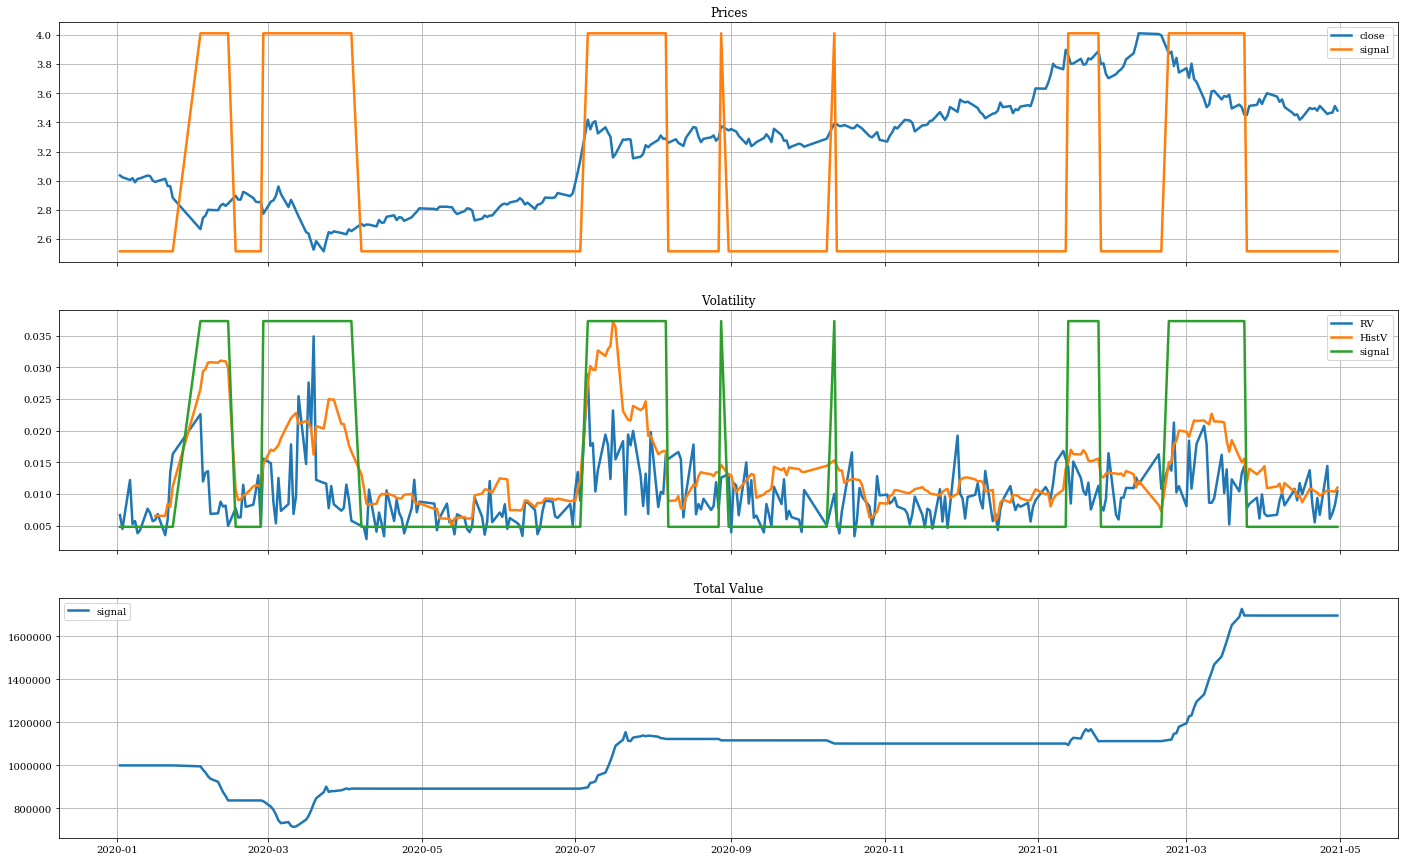

In [971]:
    # Get datetime type index for plot
    funds_dt_index = pd.DatetimeIndex(und_price.set_index(und_price['time']).index)
    # Create PRICES & VOL plot
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(24, 15), sharex=True)
    # graph1
    ax[0].plot(funds_dt_index, und_price['close'], label = 'close', lw = 2.5)
    ax[0].plot(funds_dt_index, plot_signal_ref_und_price, label = 'signal', lw = 2.5)
#    ax[0].plot(portfolio.index,
#            signal_series_for_plotting(portfolio.vol_signal,
#                                        und_price['close']),
#            label = 'vol_signal', lw = 2.5)
    ax[0].set_title('Prices')
    ax[0].legend()
    ax[0].grid(True)
    # graph2
    ax[1].plot(funds_dt_index, und_price['RV'], label = 'RV', lw = 2.5)
    ax[1].plot(funds_dt_index, und_price['HistV'], label = 'HistV', lw = 2.5)
    ax[1].plot(funds_dt_index, plot_signal_ref_HistV, label = 'signal', lw = 2.5)
    ax[1].set_title('Volatility')
    ax[1].legend()
    ax[1].grid(True)
    # graph3
    ax[2].plot(funds_dt_index, portfolio.total_value, label = 'signal', lw = 2.5)
    ax[2].set_title('Total Value')
    ax[2].legend()
    ax[2].grid(True)

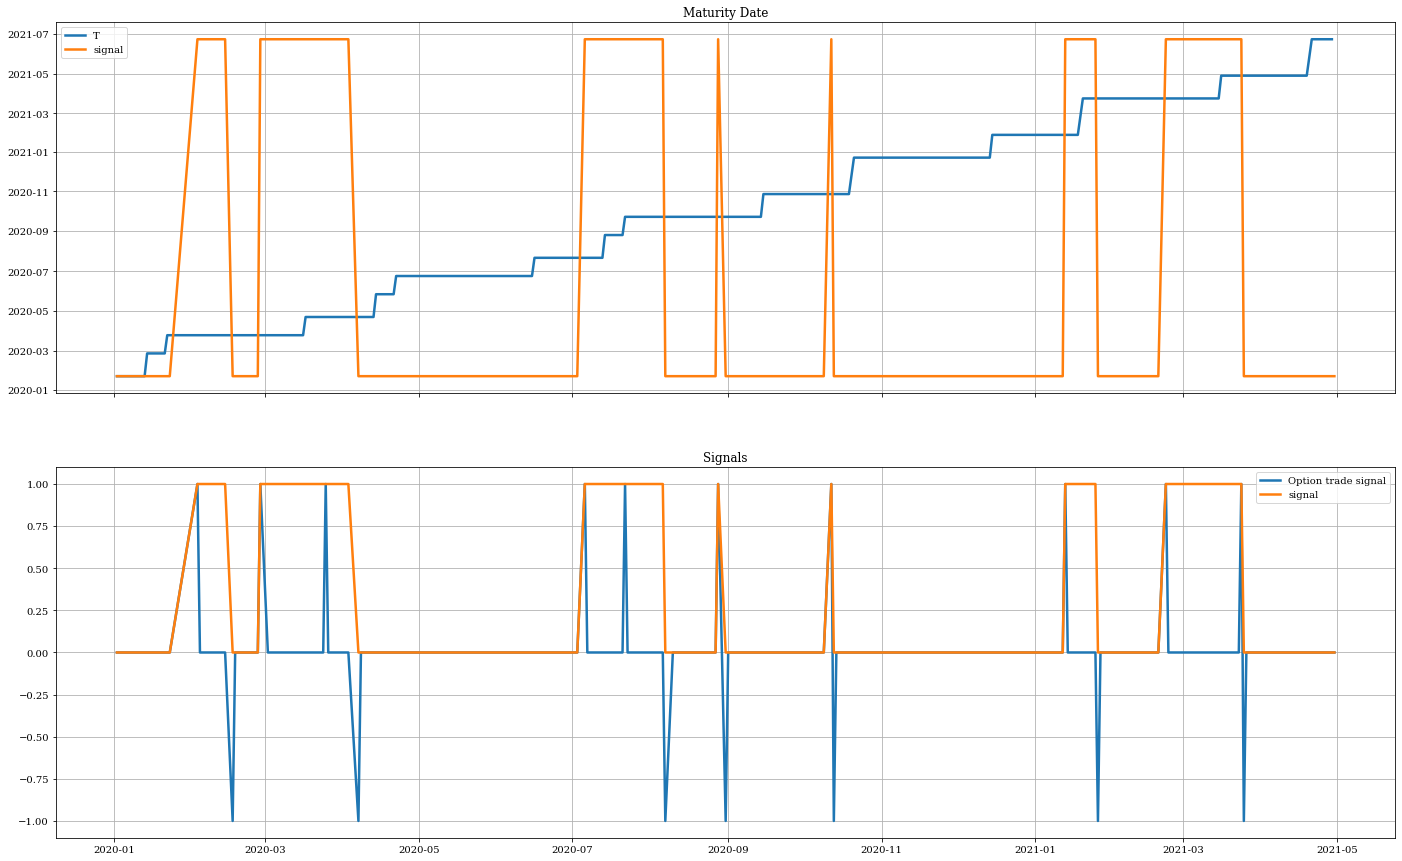

In [913]:
    # Create SIGNAL plot
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(24, 15), sharex = True)
    # graph
    ax[0].plot(selected_put.index, pd.to_datetime(selected_put.exercise_date), label = 'T', lw = 2.5)
    ax[0].plot(selected_put.index,
               signal_series_for_plotting(portfolio['vol_signal'],
                                          pd.to_datetime(selected_put.exercise_date)),
               label = 'signal', lw = 2.5)
    ax[0].set_title('Maturity Date')
    ax[0].legend()
    ax[0].grid(True)
    # graph2
    ax[1].plot(portfolio.index, portfolio.buy_signal, label = 'Option trade signal', lw = 2.5)
    ax[1].plot(portfolio.index, portfolio['vol_signal'], label = 'signal', lw = 2.5)
    ax[1].set_title('Signals')
    ax[1].legend()
    ax[1].grid(True)